In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import MetaTrader5 as mt5

TerminalInfo(community_account=False, community_connection=False, connected=True, dlls_allowed=False, trade_allowed=False, tradeapi_disabled=False, email_enabled=False, ftp_enabled=False, notifications_enabled=True, mqid=False, build=5370, maxbars=100000, codepage=0, ping_last=36318, community_balance=0.0, retransmission=0.0, company='Rico (XP Investimentos CCTVM)', name='Rico - MetaTrader 5', language='English', path='C:\\Program Files\\Rico - MetaTrader 5', data_path='C:\\Users\\jvbva\\AppData\\Roaming\\MetaQuotes\\Terminal\\38FF261A42172F3478E54D3A1A8FE02B', commondata_path='C:\\Users\\jvbva\\AppData\\Roaming\\MetaQuotes\\Terminal\\Common')
(500, 5370, '17 Oct 2025')


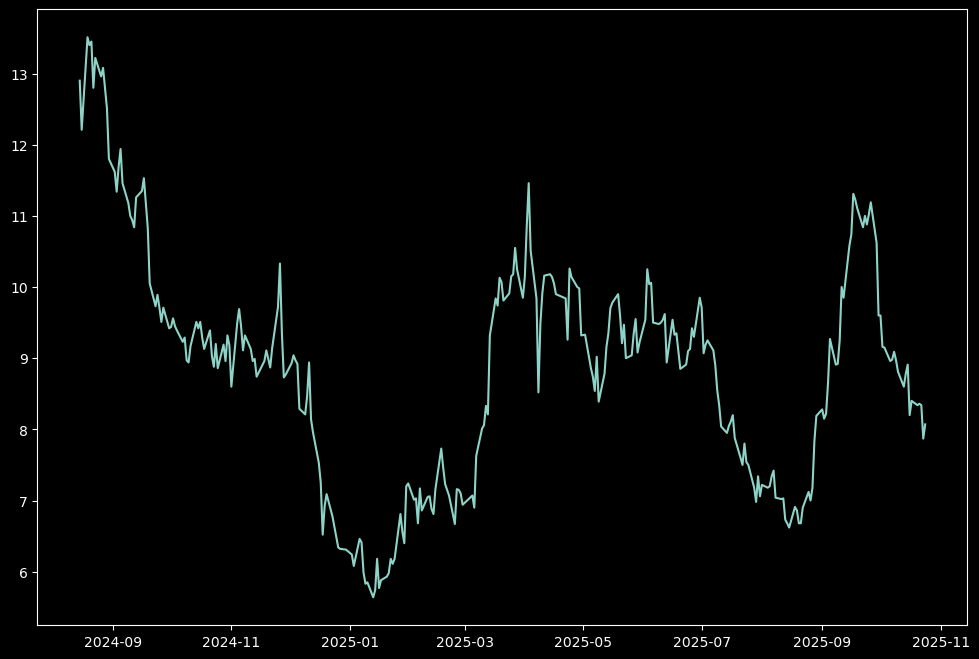

In [2]:
if not mt5.initialize():
    print("initialize() failed")
    mt5.shutdown()

# request connection status and parameters
print(mt5.terminal_info())
# get data on MetaTrader 5 version
print(mt5.version())

# request 1000 ticks from EURAUD
lastYear = datetime.now()
#mglu3 = mt5.copy_ticks_from("MGLU3", lastYear, 1000, mt5.COPY_TICKS_ALL)
#bpan4 = mt5.copy_ticks_range("BPAN4", lastYear, datetime.now(), mt5.COPY_TICKS_ALL)

# get bars from different symbols in a number of ways
rates = mt5.copy_rates_from("MGLU3", mt5.TIMEFRAME_D1, lastYear, 300)

# shut down connection to MetaTrader 5
mt5.shutdown()


#PLOT
# create DataFrame out of the obtained data
ticks_frame = pd.DataFrame(rates)
# convert time in seconds into the datetime format
ticks_frame['time'] = pd.to_datetime(ticks_frame['time'], unit='s')
#ticks_frame.set_index("time", inplace=True)
# display ticks on the chart
plt.figure(figsize=(12, 8))
plt.plot(ticks_frame['time'], ticks_frame['close'])
#ticks_frame.plot.line(y='bid', label='bid')

# display the legends
# plt.legend(loc='upper left')
# plt.title('EURAUD ticks')
plt.show()

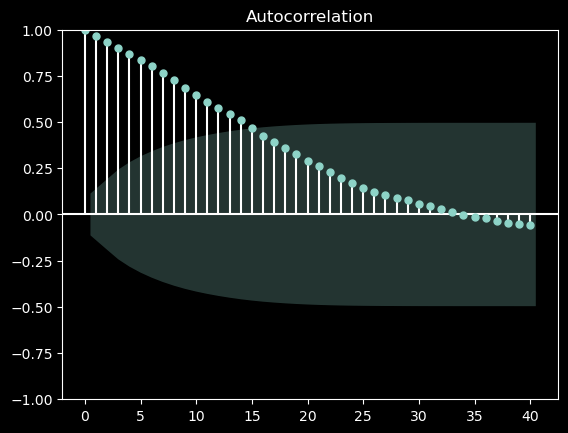

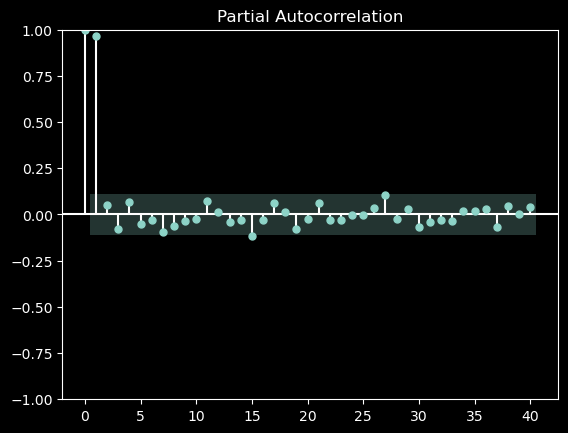

In [3]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ticks_frame['close'], lags=40)
plot_pacf(ticks_frame['close'], lags=40)
plt.show()

In [4]:
from statsmodels.tsa.arima.model import ARIMA

order=(0, 1, 1)
ArimaModel = ARIMA(ticks_frame['close'], order=order)
model_fit = ArimaModel.fit()
forecast = model_fit.get_forecast(steps=30)

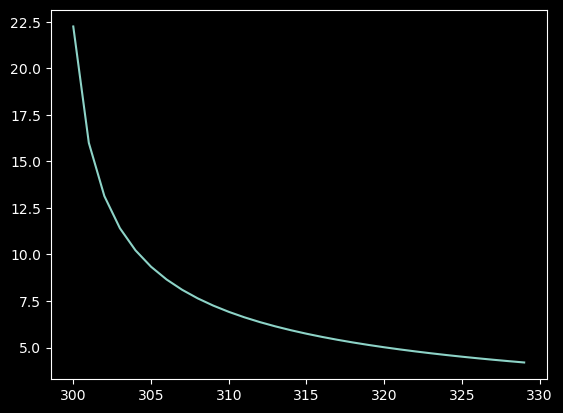

In [5]:

plt.plot(forecast.tvalues)
plt.show()

RMSE: 0.6796602503646033


C:\Users\jvbva\miniconda3\envs\market-data\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


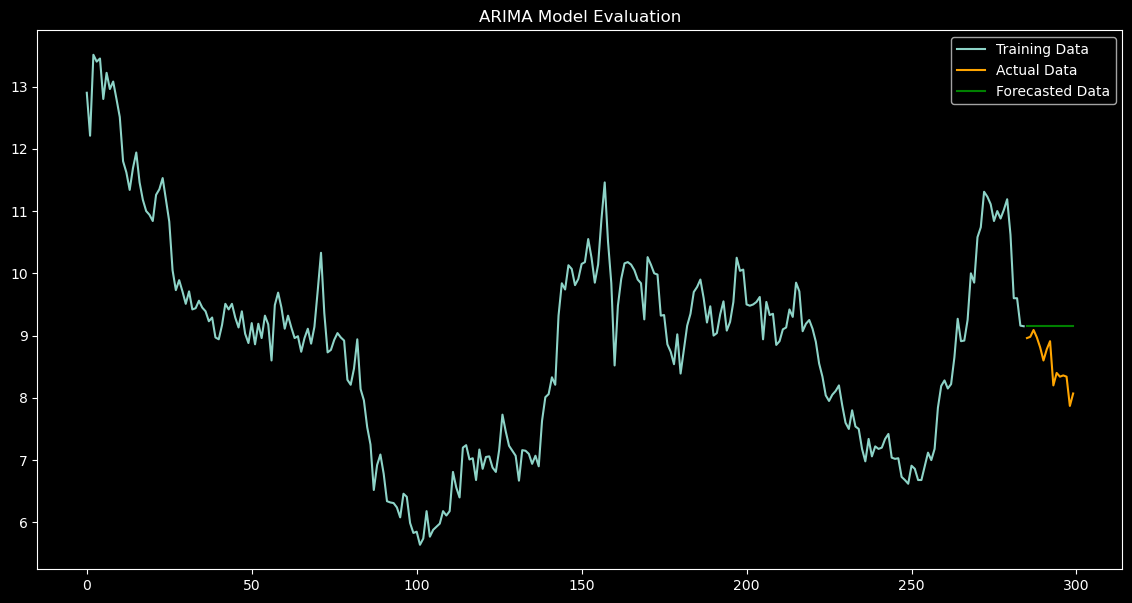

In [6]:
from sklearn.metrics import mean_squared_error

# Split the data into train and test
length = len(ticks_frame)
split_factor = 0.95
train, test = np.split(ticks_frame, [int(split_factor * length)])

# Fit the ARIMA model on the training dataset
model_train = ARIMA(train['close'],  order=order)
model_train_fit = model_train.fit()

# Forecast on the test dataset
test_forecast = model_train_fit.get_forecast(steps=len(test))
test_forecast_series = pd.Series(test_forecast.predicted_mean, index=test.index)

# Calculate the mean squared error
mse = mean_squared_error(test['close'], test_forecast_series)
rmse = mse**0.5
print(f"RMSE: {rmse}")

# Create a plot to compare the forecast with the actual test data
plt.figure(figsize=(14,7))
plt.plot(train['close'], label='Training Data')
plt.plot(test['close'], label='Actual Data', color='orange')
plt.plot(test_forecast_series, label='Forecasted Data', color='green')
plt.fill_between(test.index,
                 test_forecast.conf_int().iloc[:, 0],
                 test_forecast.conf_int().iloc[:, 1],
                 color='k', alpha=.15)
plt.title('ARIMA Model Evaluation')
plt.legend()
plt.show()


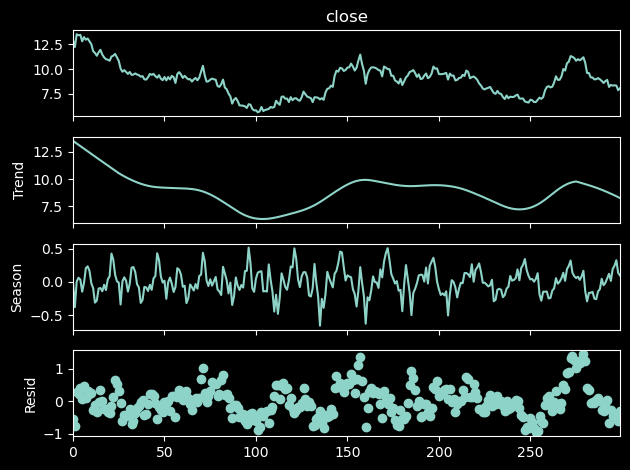

In [7]:
from statsmodels.tsa.seasonal import STL

stl = STL(ticks_frame['close'], period=25, seasonal=7, seasonal_deg=0)
res = stl.fit()
plt.figure(figsize=(14,7))
res.plot()

<Figure size 1400x700 with 0 Axes>

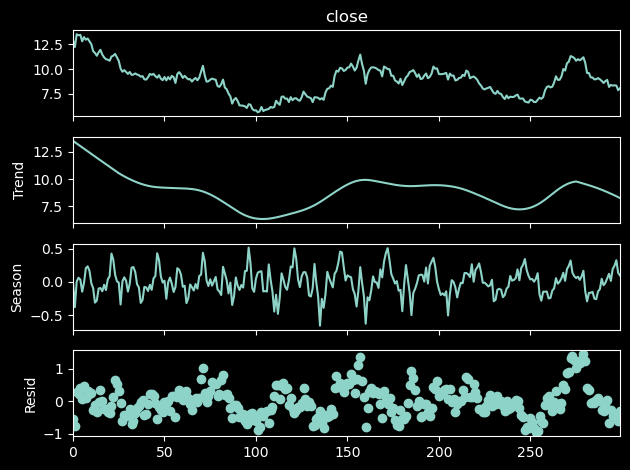

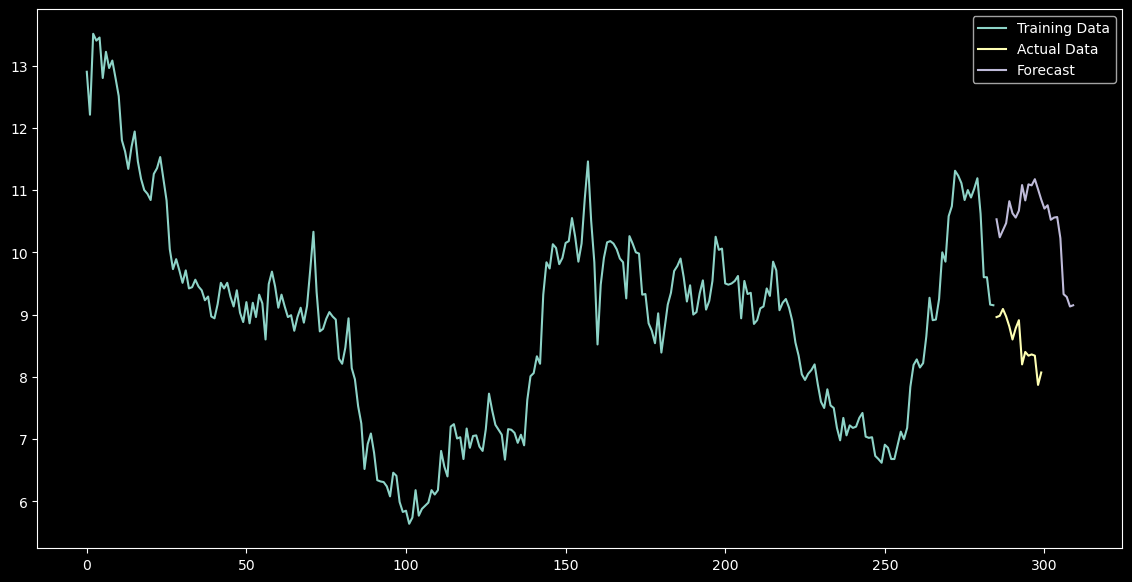

RMSE: 2.2670242582449056
                    STL Decomposition and SARIMAX Results                     
Dep. Variable:                      y   No. Observations:                  285
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -60.890
Date:                Sun, 26 Oct 2025   AIC                            125.780
Time:                        19:01:07   BIC                            133.078
Sample:                             0   HQIC                           128.706
                                - 285                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0561      0.057      0.981      0.327      -0.056       0.168
sigma2         0.0899      0.007     12.920      0.000       0.076       0.104
Ljung-Box (L1) (Q):        

In [8]:
from statsmodels.tsa.forecasting.stl import STLForecast

stlf = STLForecast(train['close'], ARIMA, period=25, model_kwargs=dict(order=order))
stlf_res = stlf.fit()

forecast = stlf_res.forecast(len(test) + 10)
plt.figure(figsize=(14,7))
plt.plot(train['close'], label='Training Data')
plt.plot(test['close'], label='Actual Data')
plt.plot(forecast, label='Forecast')
plt.legend()
plt.show()

mse = mean_squared_error(test['close'], forecast.iloc[:len(test)])
rmse = mse**0.5

print(f"RMSE: {rmse}")
print(stlf_res.summary())


In [9]:
from pmdarima.arima import ADFTest, auto_arima

adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(ticks_frame['close'])

(0.16062892708634394, True)

In [10]:
arima = auto_arima(train['close'], d=1, max_d=20, start_p=0, max_p= 10, start_q=0, max_q=10, seasonal=True, trace=True, stepwise=True, error_action='warn', m=7)

print(arima.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=242.072, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=240.817, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=242.680, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=243.014, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=239.184, Time=0.03 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=240.983, Time=0.09 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=241.314, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=242.639, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=242.627, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=244.085, Time=0.24 sec

Best model:  ARIMA(0,1,0)(0,0,0)[7]          
Total fit time: 1.297 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  285
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -1